#Identificando Linhas de Códigos Comentadas em Repositórios de Software
### Vitor Botelho Vaz de Melo

In [ ]:
print(1+1)

## Introdução
Uma prática de programação muito comum ao se desenvolver softwares é a de ”remover” uma linha ou um bloco de código tornando-os comentários, sendo conhecida como commented-out code . Esta prática se torna um verdadeiro problema quando estes códigos comentados estão inseridos em um sistema grande, complexo e mantido por diversas pessoas.

A inserção de commented-out code nos arquivos fontes de um sistema pode causar redução da legibilidade, distração e perda de tempo. Martin R., em seu livro clássico, Clean Code, enfatiza “Few practices are as odious as commenting-out code. Don’t do this!”, ele argumenta que outras pessoas não terão coragem de deletar este código por achar que ele pode ser importante. 

## Objetivo
O objetivo deste trabalho é desenvolver uma ferramenta capaz de separar comentários reais de commented-out code. Para isso foi treinado um modelo de classificação utilizando técnicas de aprendizado de máquina.

## Obtenção e pré-processamento dos dados

Para o treinamento do modelo foi necessário a criação de uma base de dados de treino. Para a constituição da base foram feitas as seguintes atividades anteriormente a execução deste notebook.

### Download de repositórios de software

Foi utilizado a api do github para escolher os repositórios de código aberto com uma boa evolução e atividade. Isso se traduz nos critérios:

* Pegar os 10 primeiros repositórios mais populares por linguagem de programação ( com mais estrelas)
* O primeiro commit deve ter mais de 2 anos
* O último commit deve ter menos de 1 mês
* As linguagens utilizadas foram C, Java, Javascript e Typescript. 

### Separação de comentários e código

Foi realizada a separação do código fonte em linhas de código e em comentários, e uma expressão regular foi utilizada para essa operação.

### Definição dos dados de treino

Após a separação em código e comentário foi definido o modelo final para os dados de treino, no qual para cada linha temos se é um comentário (0) ou código (1). Repare que neste momento ainda não foi identificado os commented-out code, portanto eles serão considerados como comentário no treino.

Os dados podem ser encontrados aqui:
[link text](https://drive.google.com/drive/folders/1K5_2cn8O-whqef41e07C-Wn-oAMGfsSU?usp=sharing)


In [0]:
#monta o drive pessoal no colab
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#import section
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, Dropout
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


Em sequência carregamos os dados de treino e de validação criados na parte de pré processamento.
Temos três colunas, a linguagem, a linha , e se ela é código ou não, em que 1 significa que é código. Os dados de treino e validação foram separado previamente, de forma aleatória.

In [0]:
PATH = 'drive/My Drive/poc_data/'
columns = ["language","line", "is_code"]
train = pd.read_csv(PATH+'train.csv', compression='gzip')
val = pd.read_csv(PATH+'val.csv', compression='gzip')
train.columns = columns
val.columns = columns

# foi identificado um problema posteriormente com o regex para python, 
# por isso foi desconsiderada para o trabalho.
train = train.drop(train.index[train['language']=='py'])
val =val.drop(val.index[val['language']=='py'])

train.sample(5)

,language,line,is_code
731642,js,"b""expect(setargs[2][0]).tobe('gl-emoji-unicode...",1.0
4534043,js,"b'require(""./mod1"");'",1.0
9449712,js,b'text += [].concat(',1.0
10336475,ts,b'const factory = this.componentfactoryresolve...,1.0
9093425,ts,"b'settext(text: string | undefined, start?: nu...",1.0


In [0]:
val.sample(5)

,language,line,is_code
456877,ts,b'export const unicode: string;',1.0
862232,c,b'chunk. this includes protocol headers as well.',0.0
575723,ts,b'column and cell layout.',0.0
728734,ts,"b""import { iworkspacecontextservice, iworkspac...",1.0
1532718,ts,b'export class textmodel extends disposable im...,1.0


Temos a quantidade de linhas que tem o dataset, para treino e validação.

In [0]:
print("Lines train: {}\nLines val: {}".format( len(train),len(val) ))

Lines train: 9936223
Lines val: 2483979


Aqui temos a distribuição do dataser por linguagem, média de 25% pra cada. C++ entrou como "intruso" por causa dos projetos em C.

In [0]:
display((train['language'].value_counts().sort_index()/len(train)*100).round(2).to_frame('language' +" (%)").T)

,c,cpp,java,js,ts
language (%),24.79,3.23,26.94,25.97,19.08


In [0]:
display((val['language'].value_counts().sort_index()/len(val)*100).round(2).to_frame('language' +" (%)").T)

,c,cpp,java,js,ts
language (%),24.81,3.22,26.97,25.96,19.04


Aqui temos a quantidade distribuição de comentários e códigos por linguagem. Na média temos 20% de comentário e 80% de código.

In [0]:
lang =['c','cpp','java','js','ts']
c = 'is_code'
for l in lang:
  df_l = train.loc[train['language'] == l]
  display((df_l[c].value_counts().sort_index()/len(df_l)*100).round(2).to_frame(c + ' ' + l +" (%)").T)

,0.0,1.0
is_code c (%),13.14,86.86


,0.0,1.0
is_code cpp (%),20.79,79.21


,0.0,1.0
is_code java (%),20.58,79.42


,0.0,1.0
is_code js (%),16.95,83.05


,0.0,1.0
is_code ts (%),29.23,70.77


In [0]:
for l in lang:
  df_l = val.loc[val['language'] == l]
  display((df_l[c].value_counts().sort_index()/len(df_l)*100).round(2).to_frame(c + ' ' + l +" (%)").T)

,0.0,1.0
is_code c (%),13.12,86.88


,0.0,1.0
is_code cpp (%),20.88,79.12


,0.0,1.0
is_code java (%),20.52,79.48


,0.0,1.0
is_code js (%),16.94,83.06


,0.0,1.0
is_code ts (%),29.27,70.73


In [0]:
A seguir definimos um dicionário criado para indexar os caracteres.
Antes defino um array com os principais caracteres das linguagens.

In [0]:
chars="abcdefghijklmnopqrstuvwxyz0123456789 -,;.!?:'\"/\|_@#$%ˆ&*˜‘+-=()[]{}<>"
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

Definimos uma função para transformar as linhas de um dataframe em um vetor de números, com os índices correspondentes para cada caractere definido acima. Os índices 0 e 1, são usados pra padding e caracteres não reconhecidos, respectivamente.
Definimos um tamanho máximo de 200 caracteres para a linha, porque é uma quantidade suficiente para identificarmos se a linha é código ou não.

In [0]:
max_len = 200
def transform_sentences(df2):
  X_char = []
  for sentence in df2['line']:
    sentence =  sentence[2:-1].lower()
    sent_seq = []
    for i in range(max_len):
      try:
        value = char2idx.get(sentence[i])
        if value == None:
          sent_seq.append(char2idx["UNK"])
        else:
          sent_seq.append(value)
      except:
        sent_seq.append(char2idx.get("PAD"))
    X_char.append(np.array(sent_seq))
  X_char = pad_sequences(maxlen=max_len, sequences=X_char, value=char2idx["PAD"], padding='post', truncating='post')
  #print(X_char[:5])
  return X_char

Agora criamos o modelo com a biblioteca do Keras. Temos uma camada de input que recebe os 200 caracteres indexados e passa para uma camada de Embedding, em que aprendemos uma representação distribuida para os caracteres de forma a facilitar o aprendizado da lstm que vem em sequência com 200 unidade. A LSTM vai poder enxergar sequências importantes de caracteres para definir se é um código ou comentário. Ao final passamos por uma camada densa de 8 neurônios, e por fim o output com um neurônio e com função de ativação sigmoid, para prevermos uma "probabilidade" entre 0 e 1 a linha.

Como foi coletado uma grande quantidade de dados, foi definido utilizar a LSTM que seria o mais "complexo" para resolver esse problema, e por esse motivo não foi feito variação de modelos e de parâmetros. Pois a partir dos primeiros testes já demonstrou a eficiência e regularização do modelo.

In [0]:
char_in = Input(shape=(max_len,))
emb_char = Embedding(input_dim=len(chars) + 2, output_dim=32,
                           input_length=max_len, mask_zero=True)(char_in)
main_lstm = LSTM(units=200, return_sequences=False,
                               recurrent_dropout=0.5)(emb_char)
out = (Dense(8,input_shape=(16,), activation='relu'))(main_lstm)
out = Dropout(0.2)(out)
out = (Dense(1, activation='sigmoid'))(out)
model = Model( char_in, out)

model.summary()

W0704 05:10:06.298085 140652779186048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 05:10:06.323045 140652779186048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 05:10:06.328094 140652779186048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 05:10:06.504160 140652779186048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0704 05:10:06.516910 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 32)           2304      
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               186400    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 190,321
Trainable params: 190,321
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])


W0704 05:10:06.850869 140652779186048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0704 05:10:06.892035 140652779186048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.



## Treinamento
A seguir é realizado o treinamento do modelo. Como foi adquirido muito dado, foi realizado um treinamento por amostra, de forma a diminuir a influência da amostra, foram retiradas 20 amostras de 100mil para treino e 20mil para validação, e o modelo foi treinado por 10 épocas para cada amostra. Ao final o modelo chegou com 98,5% de acurácia tanto para teste quanto para treino, indicando que modelo está regularizado.

In [0]:
eval_train = []
for i in range(20):
  print(i)
  filepath="drive/My Drive/hdf5_files/separatecode_sample"+str(i)+"model_weights.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor=
                               'loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]
  df2 = train.sample(n=100000)
  X = transform_sentences(df2)
                               
  df2_val = val.sample(n=20000)
  X_val = transform_sentences(df2_val)          
 
  s = model.fit(X, df2['is_code'], epochs=10, batch_size=512, validation_data=(X_val, df2_val['is_code']), callbacks=callbacks_list)
  
  eval_train.append(s)
  print(s)

0
Train on 100000 samples, validate on 20000 samples
Epoch 1/10
100000/100000 [==============================] - 132s 1ms/step - loss: 0.3199 - acc: 0.8869 - val_loss: 0.1952 - val_acc: 0.9339

Epoch 00001: loss improved from inf to 0.31989, saving model to drive/My Drive/hdf5_files/separatecode_sample0model_weights.hdf5
Epoch 2/10
100000/100000 [==============================] - 130s 1ms/step - loss: 0.1996 - acc: 0.9364 - val_loss: 0.1705 - val_acc: 0.9432

Epoch 00002: loss improved from 0.31989 to 0.19961, saving model to drive/My Drive/hdf5_files/separatecode_sample0model_weights.hdf5
Epoch 3/10
100000/100000 [==============================] - 131s 1ms/step - loss: 0.1836 - acc: 0.9425 - val_loss: 0.1568 - val_acc: 0.9476

Epoch 00003: loss improved from 0.19961 to 0.18360, saving model to drive/My Drive/hdf5_files/separatecode_sample0model_weights.hdf5
Epoch 4/10
100000/100000 [==============================] - 131s 1ms/step - loss: 0.1807 - acc: 0.9430 - val_loss: 0.1558 - val_a

In [0]:
# essa célula foi usada para recarregar os valores e peso do modelo e os dados de validação
# pois depois de algum tempo o colab reinicia o notebook, e não é viável ficar retreinando toda hora.
char_in = Input(shape=(max_len,))
emb_char = Embedding(input_dim=len(chars) + 2, output_dim=32,
                           input_length=max_len, mask_zero=True)(char_in)
main_lstm = LSTM(units=200, return_sequences=False,
                               recurrent_dropout=0.5)(emb_char)
out = (Dense(8,input_shape=(16,), activation='relu'))(main_lstm)
out = Dropout(0.2)(out)
out = (Dense(1, activation='sigmoid'))(out)
model = Model( char_in, out)


model.load_weights("drive/My Drive/hdf5_files/separatecode_sample19model_weights.hdf5")
val = pd.read_csv('drive/My Drive/poc_data/val.csv', compression='gzip')
val.columns = ["language","line", "is_code"]
val = val.drop(val.index[val['language']=='py'])

W0704 17:18:19.140309 140444482205568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 17:18:19.292987 140444482205568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0704 17:18:19.303860 140444482205568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0704 17:18:19.480102 140444482205568 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorfl

In [0]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

W0704 17:19:37.246464 140444482205568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Validação

Novamente fazemos uma batelada de 10 amostras da validação e verificamos a acurácia média, também ficando em 98%

In [0]:
acc_avg = 0
for i in range(10):
  dft = val.sample(n=20000)
  y = dft['is_code']
  X_test = transform_sentences(dft)
  _,acc = model.evaluate(X_test,y)
  acc_avg += acc
  
print('Acurácia média: ' + str(acc_avg/10))

20000/20000 [==============================] - 82s 4ms/step
Acurácia média: 0.9844200000000001


In [0]:

def ROC_CURVE(y,p):
  fpr, tpr, tresh = metrics.roc_curve(y, p)
  roc_auc = metrics.auc(fpr, tpr)
  plt.figure(figsize=(7, 7))
  lw = 2
  plt.plot(fpr, tpr,label='LSTM Classifier (area = %0.3f)' % roc_auc, color='royalblue',lw=2)
  plt.plot([0, 1], [0, 1], color='Black', lw=2, ls='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Curva ROC')
  plt.legend(loc="lower right")
  plt.show()

Agora pegamos uma amostra e plotamos a ROC_CURVE, que obteve uma área abaixo da curva de 0.99, mostrando que o modelo separa com quase perfeição os dados.

In [0]:
dft = val.sample(n=20000)
y = dft['is_code']
X_test = transform_sentences(dft)
pred = model.predict(X_test)
y = dft['is_code']


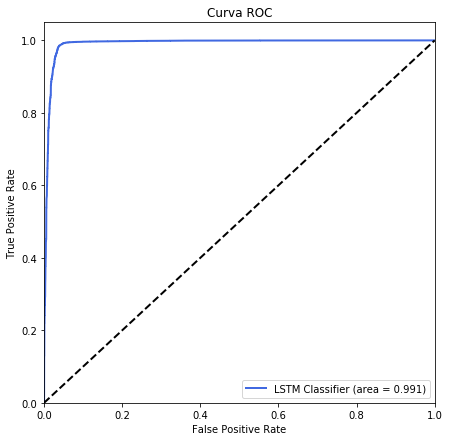

In [0]:
ROC_CURVE(y,pred)

In [0]:
def show_conf_matrix(p,y,treshold):
  p2 = [1 if pred > treshold else 0 for pred in p]
  cm = metrics.confusion_matrix(y, p2)
  (tn, fp, fn, tp) = cm.ravel()
  precision = tp/(tp+fp)
  revoc = tp/(tp+fn)
  acc = (tp+tn)/(tn+fn+fp+tp)
  print('Precisão:' + str(precision))
  print('Revocação:' + str(revoc))
  print('Acurácia:' + str(acc))
  
  
  fig, ax = plt.subplots(figsize=(7, 7))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         xticklabels=['comment','code'], yticklabels=['comment','code'],
         title="Matriz de Confusão - Treshold: " + str(treshold),
         ylabel="Real",
         xlabel="Predito")

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], "d"),
              ha="center", va="center",
              color="white" if cm[i, j] > cm.max()/2. else "black")
  fig.tight_layout()
  plt.show()
  
  

Verifiquei agora a precisão, revocação para a classe positiva e acurácia para diferentes tresholds da saída. Foi escolhido o valor de 0.6, por manter a maior acurácia e equilibrio entre precisão e revocação

Precisão:0.982366084908509
Revocação:0.9955933655670481
Acurácia:0.9818


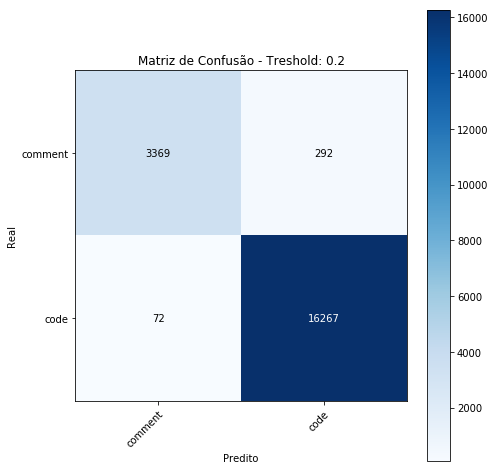

Precisão:0.9856267814906907
Revocação:0.9946753167268498
Acurácia:0.9838


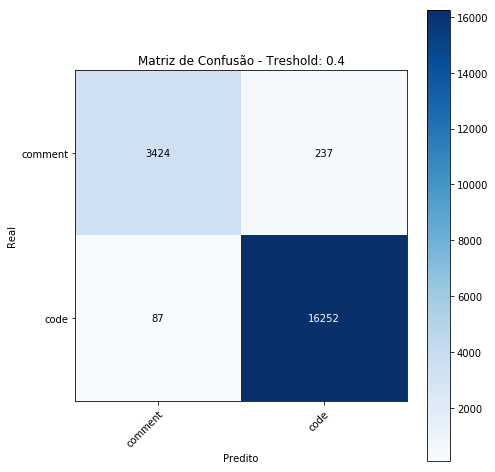

Precisão:0.9866375121477162
Revocação:0.9941856906787441
Acurácia:0.98425


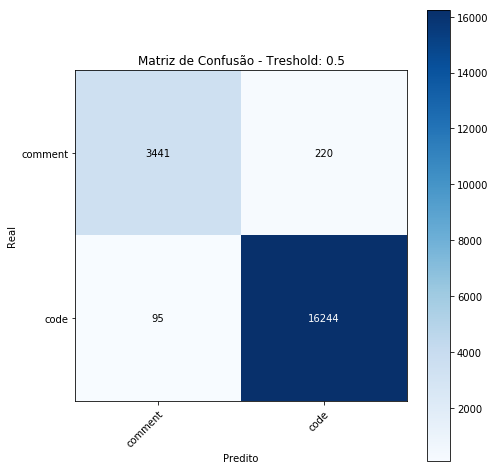

Precisão:0.987532688682114
Revocação:0.9938184711426647
Acurácia:0.9847


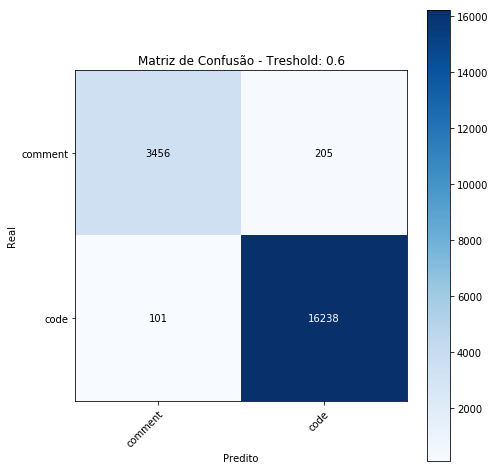

Precisão:0.9891934794554003
Revocação:0.9916151539261888
Acurácia:0.9843


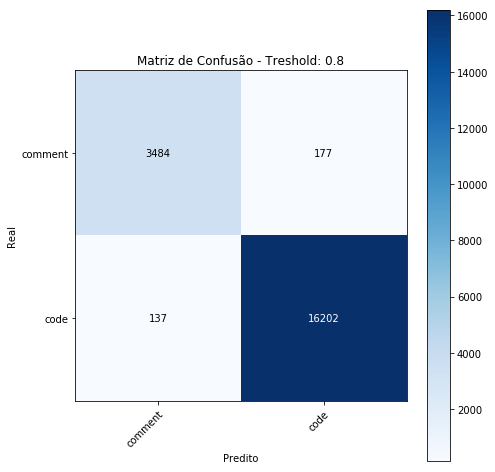

In [0]:
for tresh in [0.2,0.4,0.5,0.6,0.8]:
  show_conf_matrix(pred,y, tresh)

Na sequência foi feito uma amostragem por linguagem, novamente temos um desempenho regular.
A única excessão foi a linguagem typescript, que teve a acurácia um pouco menor. Isso faz sentido pois ela tem uma distribuição maior de comentários, que é onde estão os ruídos (códigos removidos por comentário). 




java: 
Precisão:0.9957393483709274
Revocação:0.9984920834380497
Acurácia:0.9954


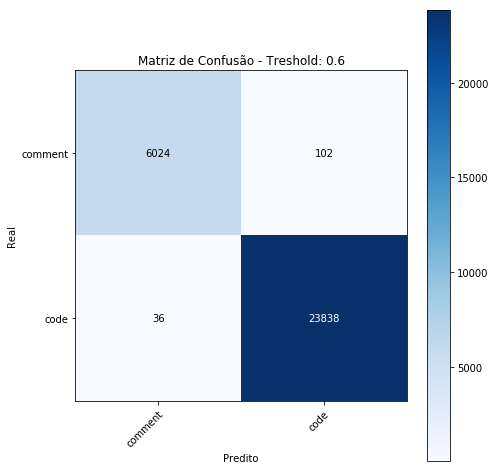




c: 
Precisão:0.9938285714285714
Revocação:0.9985455102197045
Acurácia:0.9933333333333333


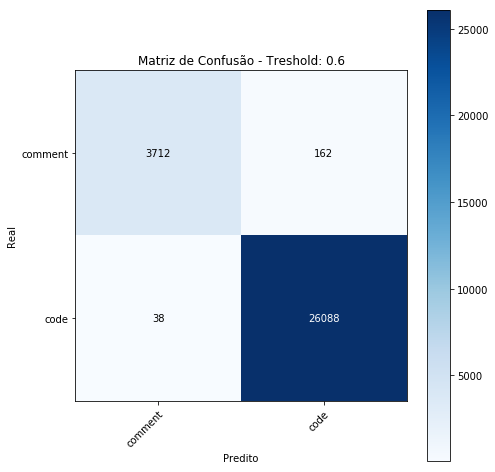




js: 
Precisão:0.9869179068650984
Revocação:0.9941164618174492
Acurácia:0.9842333333333333


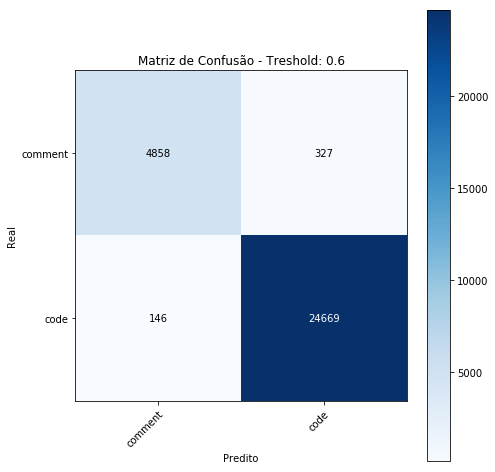




ts: 
Precisão:0.9713137472283814
Revocação:0.9931982428794105
Acurácia:0.9745


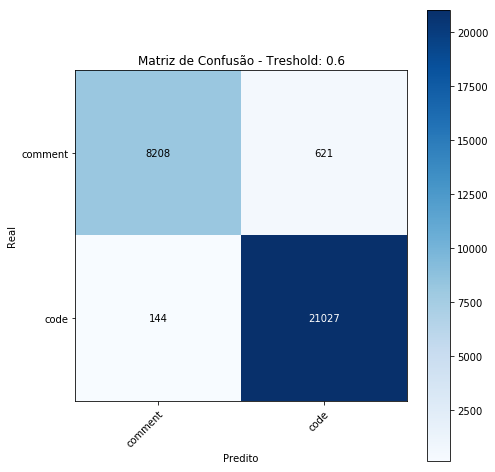

In [0]:

for lang in ['java','c','js','ts']:
  print('\n\n')
  dft = val.loc[val['language'] == lang].sample(n=30000)
  y_tl = dft['is_code']
  X_tl = transform_sentences(dft)
  #_,acc = model.evaluate(X_tl,y_tl)
  p_tl = model.predict(X_tl)
  
  print(lang+': ')
  show_conf_matrix(p_tl,y_tl, 0.6)

In [0]:

dft = val.loc[ (val['is_code'] == 0)].sample(n=3000)
y_tl = dft['is_code']
X_tl = transform_sentences(dft)
p_tl = model.predict(X_tl)


Podemos observar os ruídos abaixo, que são os valores que a rede preveu "errado" para comentários.

In [0]:
for i in range(len(p_tl)):
  if(p_tl[i] > 0.6 ):
    print(dft.iloc[i]['language'],dft.iloc[i]['line'], dft.iloc[i]['is_code'], p_tl[i])

ts b"import y6 = require('')" 0.0 [0.99285567]
js b"object.defineproperty(array.prototype, 'locale', {" 0.0 [0.9958383]
cpp b'utzfmt_style_localized_gmt_short,' 0.0 [0.9996971]
js b"var object = { 'a': 1, 'b': '2', 'c': 3 };" 0.0 [0.96133006]
js b'return' 0.0 [0.85619104]
c b'1.0000000000000000000000e0,' 0.0 [0.99903846]
js b'undefined' 0.0 [0.6299838]
ts b'var tv = m.transformpoint(v);' 0.0 [0.963693]
ts b'<select [comparewith]="comparefn"  [formcontrol]="selectedcountriescontrol">' 0.0 [0.96646786]
js b'cut: {{cut}}' 0.0 [0.8974657]
ts b"'\\t\\t}'," 0.0 [0.99851227]
java b'public class simplecontroller {' 0.0 [0.9963625]
js b'var use_glo_m4_private_v2_private: use_glo_m4_private;' 0.0 [0.9804751]
js b'"either:' 0.0 [0.99474216]
java b'} finally {' 0.0 [0.99437374]
ts b'let files: configfiles;' 0.0 [0.9870527]
ts b'@deprecated' 0.0 [0.6157757]
js b'scope.counter = scope.counter + 1;' 0.0 [0.9935881]
ts b"var webview = gui.open('fs:index.html');" 0.0 [0.91310453]
js b'assert node match

Aqui temos os comentários reais e corretos.

In [0]:
for i in range(len(p_tl)):
  if(p_tl[i] < 0.6 ):
    print(dft.iloc[i]['language'],dft.iloc[i]['line'], dft.iloc[i]['is_code'], p_tl[i])

js b'"as is" and any express or implied warranties, including, but not' 0.0 [0.00043842]
ts b'time constants for simple exponential ramps. if' 0.0 [0.06642044]
ts b'connects specified obj/event to specified method of this object' 0.0 [0.00031778]
ts b'function to get an observable that tells when to close the buffer.</span>' 0.0 [0.03997916]
js b'modification, are permitted provided that the following conditions are' 0.0 [0.00055695]
js b'set the contents as newtext' 0.0 [0.00370184]
js b'value' 0.0 [0.05189577]
ts b'@returns the views instance' 0.0 [1.7881393e-07]
java b'this is a proxy so it should be reset to default' 0.0 [0.01274592]
ts b'@param term the search term.' 0.0 [1.5944242e-05]
c b'an array of sds where even strings are slots and odd' 0.0 [0.00618088]
js b'arraytype' 0.0 [0.00968164]
js b'assets' 0.0 [0.12534797]
c b'helper function for exprisdeterministic().' 0.0 [0.01593208]
js b'check#1' 0.0 [1.7940998e-05]
js b'@param {function} func the function to modify.' 0.0 [3.69

## Conclusão

Podemos concluir que o modelo aprendeu muito bem a diferenciar comentários reais de código. Mostrando que a LSTM também pode encontrar padrões "estruturais" em sequências de caracteres.

Como trabalho futuro, esta ferramenta servirá para estudar a prática de commenting-out code em diversos repositórios.

Um teste interessante  que ainda poderia ser feitos seria verificar a acurácia para linguagens que não foram treinadas no modelo.